# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

2024-03-24 04:25:47.557463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


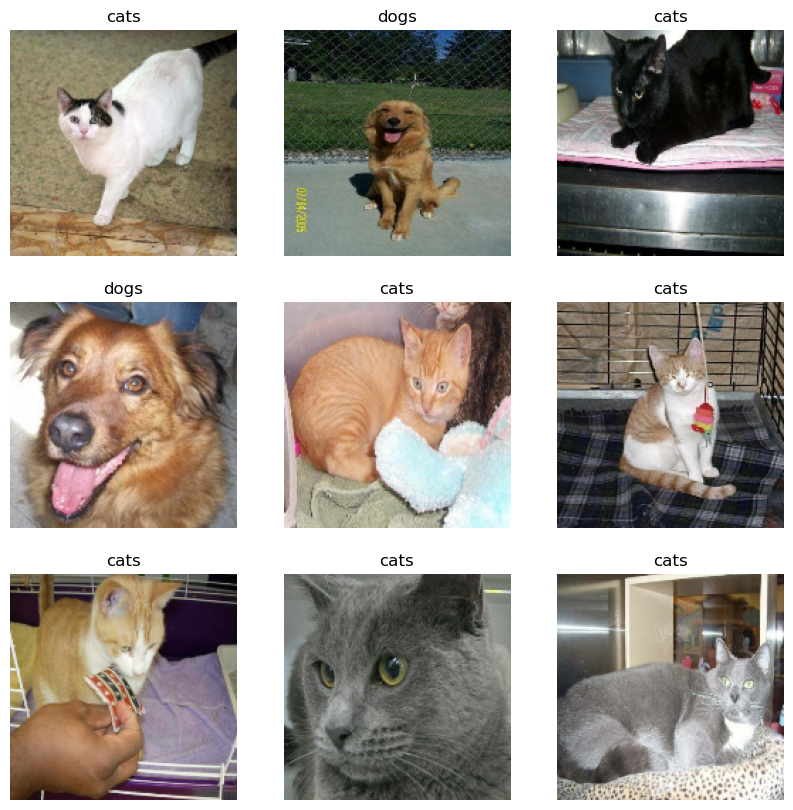

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

2024-03-24 04:25:48.598967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


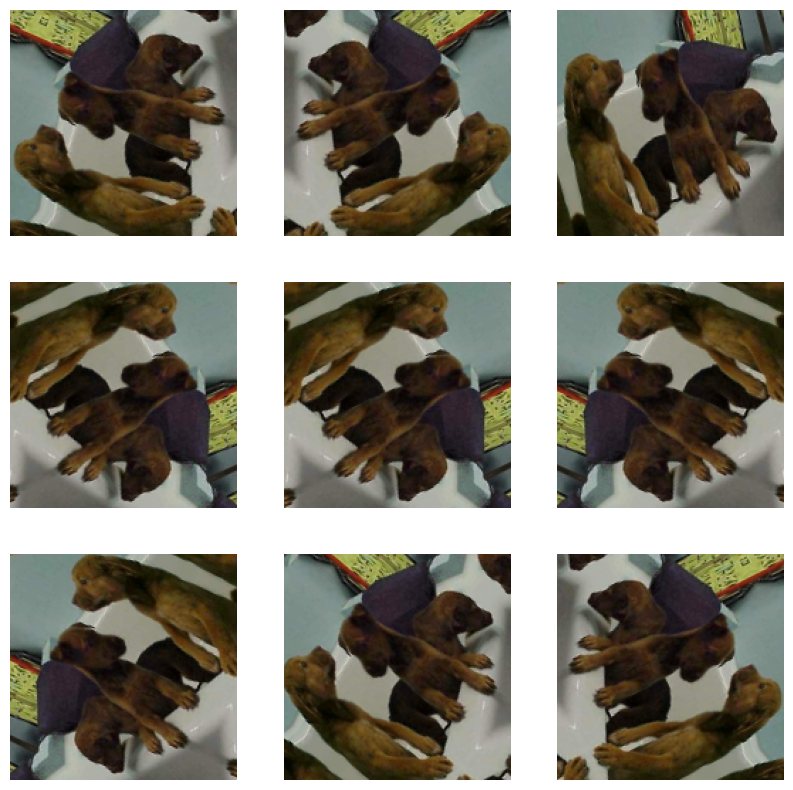

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [11]:
preprocess_input_v1 = tf.keras.applications.mobilenet.preprocess_input
preprocess_input_v2 = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input_v3 = tf.keras.applications.mobilenet_v3.preprocess_input


Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [13]:
# Create the base model from the pre-trained models MobileNet, MobileNet V2, and MobileNet V3
IMG_SHAPE = IMG_SIZE + (3,)

# Creating the base model from MobileNet.
base_model_v1 = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


# Creating the base model from MobileNet V2.
base_model_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

# Creating the base model from MobileNet V3 Large.
base_model_v3 = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                       include_top=False,
                                                       weights='imagenet')

/Users/kapilwanaskar/anaconda3/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch_v1 = base_model_v1(image_batch)
feature_batch_v2 = base_model_v2(image_batch)
feature_batch_v3 = base_model_v3(image_batch)

print("MobileNet Feature Batch Shape:", feature_batch_v1.shape)
print("MobileNetV2 Feature Batch Shape:", feature_batch_v2.shape)
print("MobileNetV3 Feature Batch Shape:", feature_batch_v3.shape)

MobileNet Feature Batch Shape: (32, 5, 5, 1024)
MobileNetV2 Feature Batch Shape: (32, 5, 5, 1280)
MobileNetV3 Feature Batch Shape: (32, 5, 5, 960)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [15]:
base_model_v1.trainable = False
base_model_v2.trainable = False
base_model_v3.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [16]:
# Let's take a look at the base model architecture for both models
print("\nMobileNet Architecture")
base_model_v1.summary()

print("MobileNetV2 Architecture")
base_model_v2.summary()

print("MobileNetV3 Architecture")
base_model_v3.summary()


MobileNet Architecture


Model: "mobilenet_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 80, 80, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 80, 80, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 80, 80, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 80, 80, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 81, 81, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 40, 40, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 40, 40, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 40, 40, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 40, 40, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

MobileNetV2 Architecture


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNetV3 Architecture


Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 80, 80,    │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 80, 80,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 80, 80,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 80, 80,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 81, 81,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [17]:
global_average_layer_v1 = tf.keras.layers.GlobalAveragePooling2D()
global_average_layer_v2 = tf.keras.layers.GlobalAveragePooling2D()  
global_average_layer_v3 = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average_v1 = global_average_layer_v1(feature_batch_v1)  
feature_batch_average_v2 = global_average_layer_v2(feature_batch_v2)
feature_batch_average_v3 = global_average_layer_v3(feature_batch_v3)


print("MobileNet Feature Batch Average Shape:", feature_batch_average_v1.shape)
print("MobileNetV2 Feature Batch Average Shape:", feature_batch_average_v2.shape)
print("MobileNetV3 Feature Batch Average Shape:", feature_batch_average_v3.shape)

MobileNet Feature Batch Average Shape: (32, 1024)
MobileNetV2 Feature Batch Average Shape: (32, 1280)
MobileNetV3 Feature Batch Average Shape: (32, 960)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [18]:
# Define separate prediction layers for each model version to avoid shape incompatibility
prediction_layer_v1 = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_layer_v2 = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_layer_v3 = tf.keras.layers.Dense(1, activation='sigmoid')

prediction_batch_v1 = prediction_layer_v1(feature_batch_average_v1)
prediction_batch_v2 = prediction_layer_v2(feature_batch_average_v2)
prediction_batch_v3 = prediction_layer_v3(feature_batch_average_v3)

print("MobileNet Prediction Batch Shape:", prediction_batch_v1.shape)
print("MobileNetV2 Prediction Batch Shape:", prediction_batch_v2.shape)
print("MobileNetV3 Prediction Batch Shape:", prediction_batch_v3.shape)

MobileNet Prediction Batch Shape: (32, 1)
MobileNetV2 Prediction Batch Shape: (32, 1)
MobileNetV3 Prediction Batch Shape: (32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))

# MobileNet
x_v1 = data_augmentation(inputs)
x_v1 = preprocess_input_v1(x_v1)
x_v1 = base_model_v1(x_v1, training=False)
x_v1 = global_average_layer_v1(x_v1)
x_v1 = tf.keras.layers.Dropout(0.2)(x_v1)
outputs_v1 = prediction_layer_v1(x_v1)
model_v1 = tf.keras.Model(inputs, outputs_v1)

# MobileNet V2
x_v2 = data_augmentation(inputs)
x_v2 = preprocess_input_v2(x_v2)
x_v2 = base_model_v2(x_v2, training=False)
x_v2 = global_average_layer_v2(x_v2)
x_v2 = tf.keras.layers.Dropout(0.2)(x_v2)
outputs_v2 = prediction_layer_v2(x_v2)
model_v2 = tf.keras.Model(inputs, outputs_v2)

# MobileNet V3
x_v3 = data_augmentation(inputs)
x_v3 = preprocess_input_v3(x_v3)
x_v3 = base_model_v3(x_v3, training=False)
x_v3 = global_average_layer_v3(x_v3)
x_v3 = tf.keras.layers.Dropout(0.2)(x_v3)
outputs_v3 = prediction_layer_v3(x_v3)
model_v3 = tf.keras.Model(inputs, outputs_v3)

In [20]:
print("\nMobileNet Model Summary")
model_v1.summary()

print("MobileNet V2 Model Summary")
model_v2.summary()

print("MobileNet V3 Model Summary")
model_v3.summary()


MobileNet Model Summary


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_160 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

MobileNet V2 Model Summary


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNet V3 Model Summary


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [21]:
# The trainable parameters in MobileNet
print("MobileNet Trainable Parameters:", len(model_v1.trainable_variables))

# The trainable parameters in MobileNet V2
print("\nMobileNet V2 Trainable Parameters:", len(model_v2.trainable_variables))

# The trainable parameters in MobileNet V3
print("MobileNet V3 Trainable Parameters:", len(model_v3.trainable_variables))

MobileNet Trainable Parameters: 2

MobileNet V2 Trainable Parameters: 2
MobileNet V3 Trainable Parameters: 2



MobileNet Plot Model


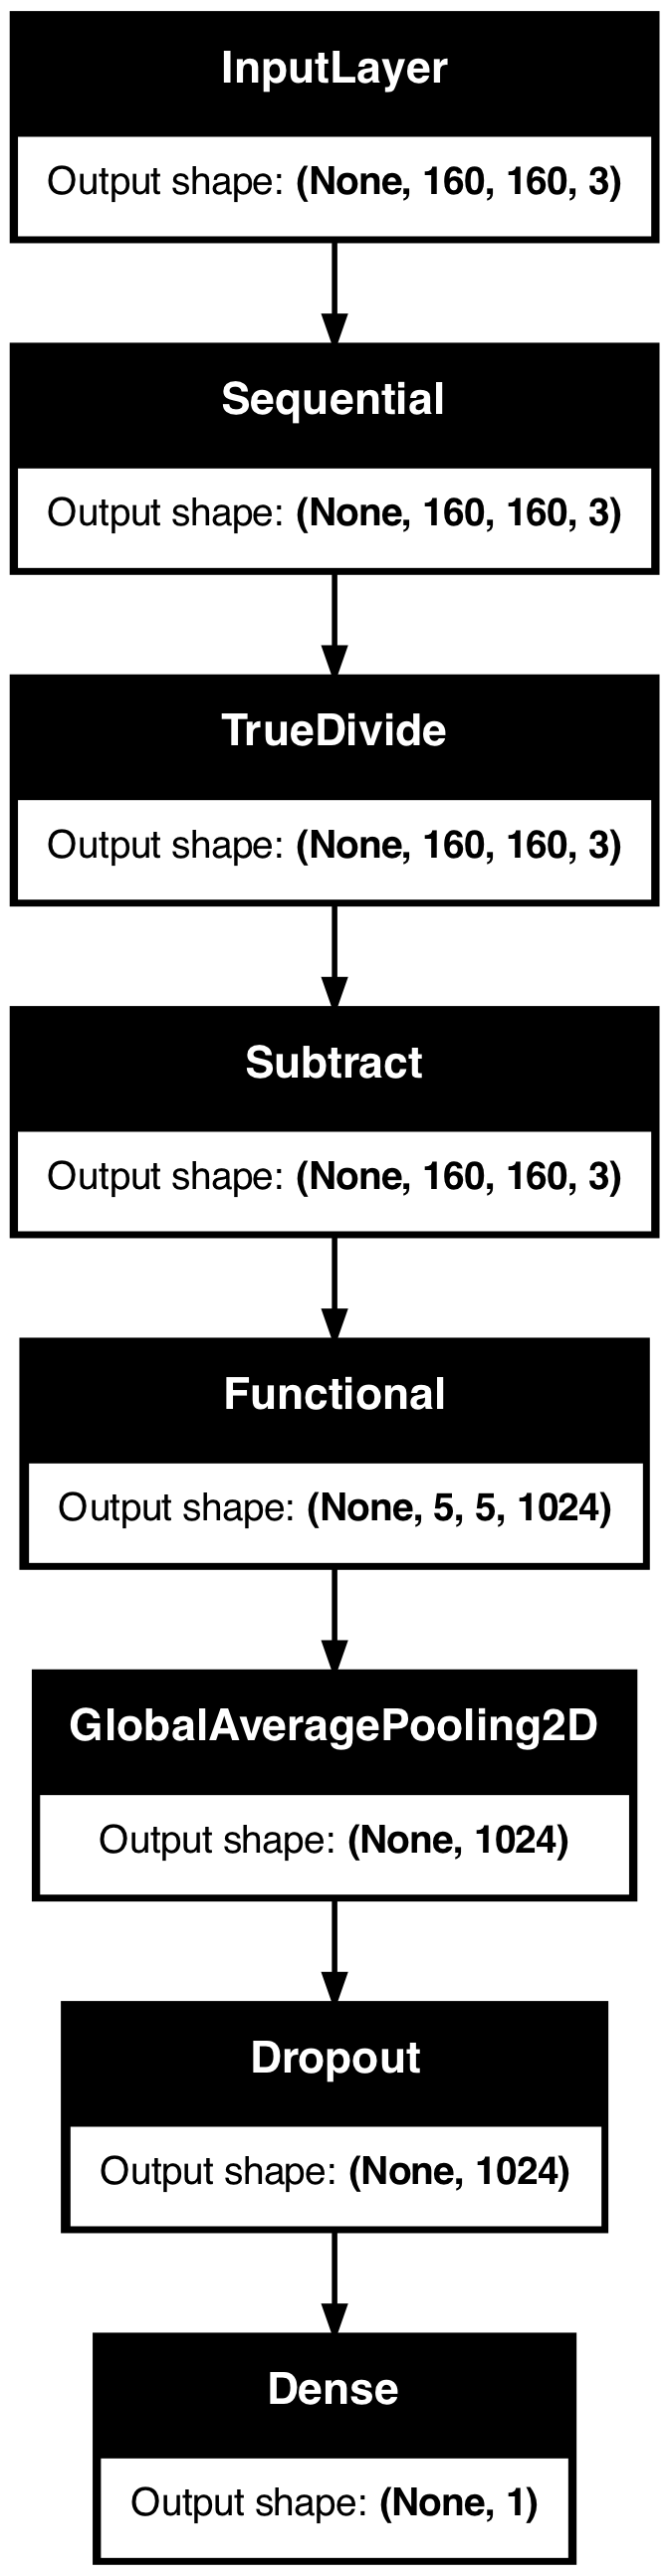

In [22]:
# Plot model for MobileNet
print("\nMobileNet Plot Model")
tf.keras.utils.plot_model(model_v1, show_shapes=True)


MobileNet Plot Model


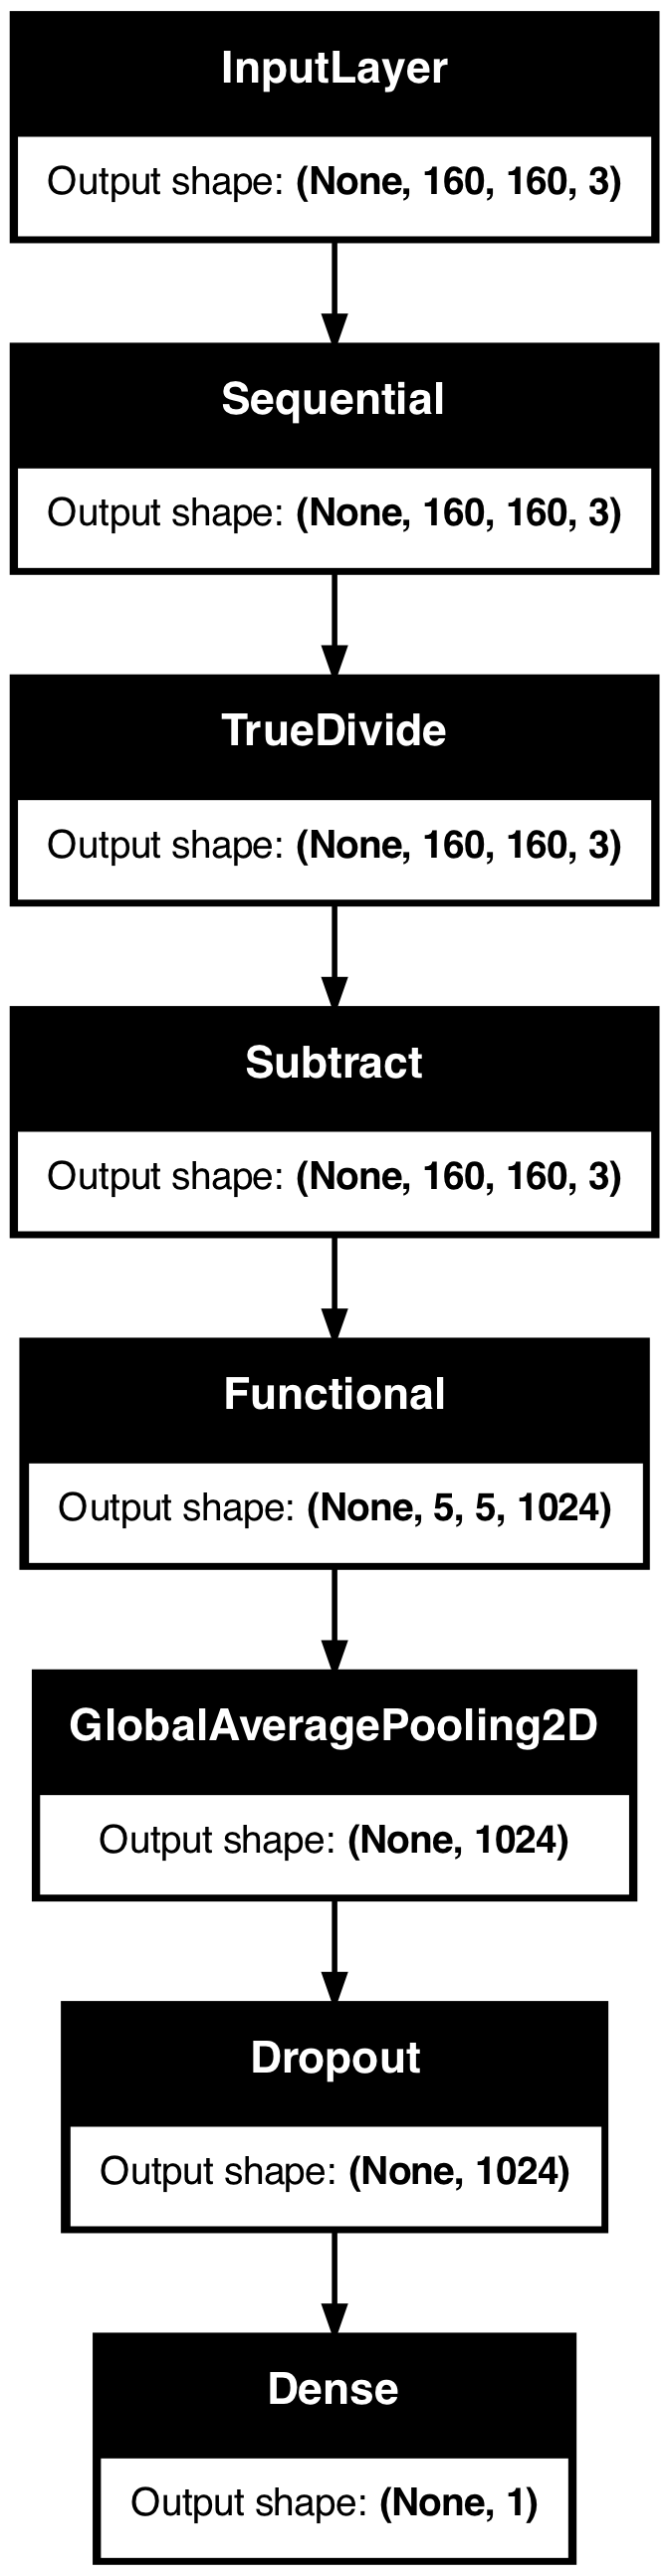

In [23]:
# Plot model for MobileNet
print("\nMobileNet Plot Model")
tf.keras.utils.plot_model(model_v1, show_shapes=True)


MobileNet V2 Plot Model


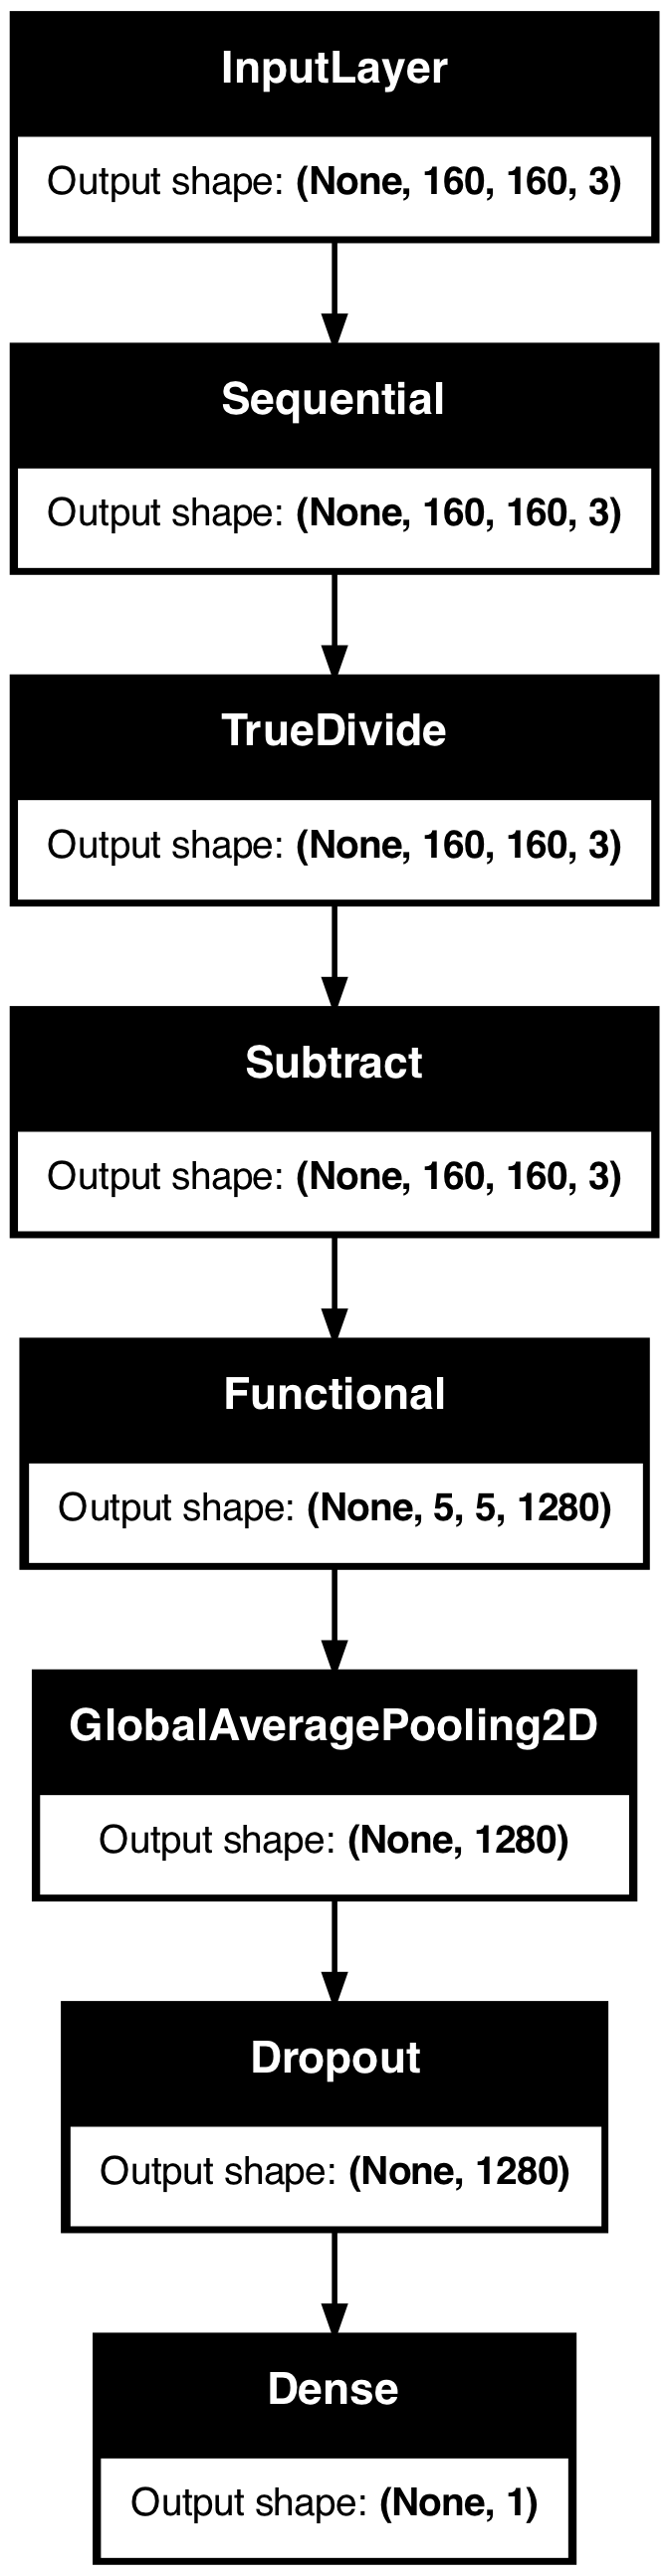

In [24]:
# Plot model for MobileNet V2
print("\nMobileNet V2 Plot Model")
tf.keras.utils.plot_model(model_v2, show_shapes=True)


MobileNet V3 Plot Model


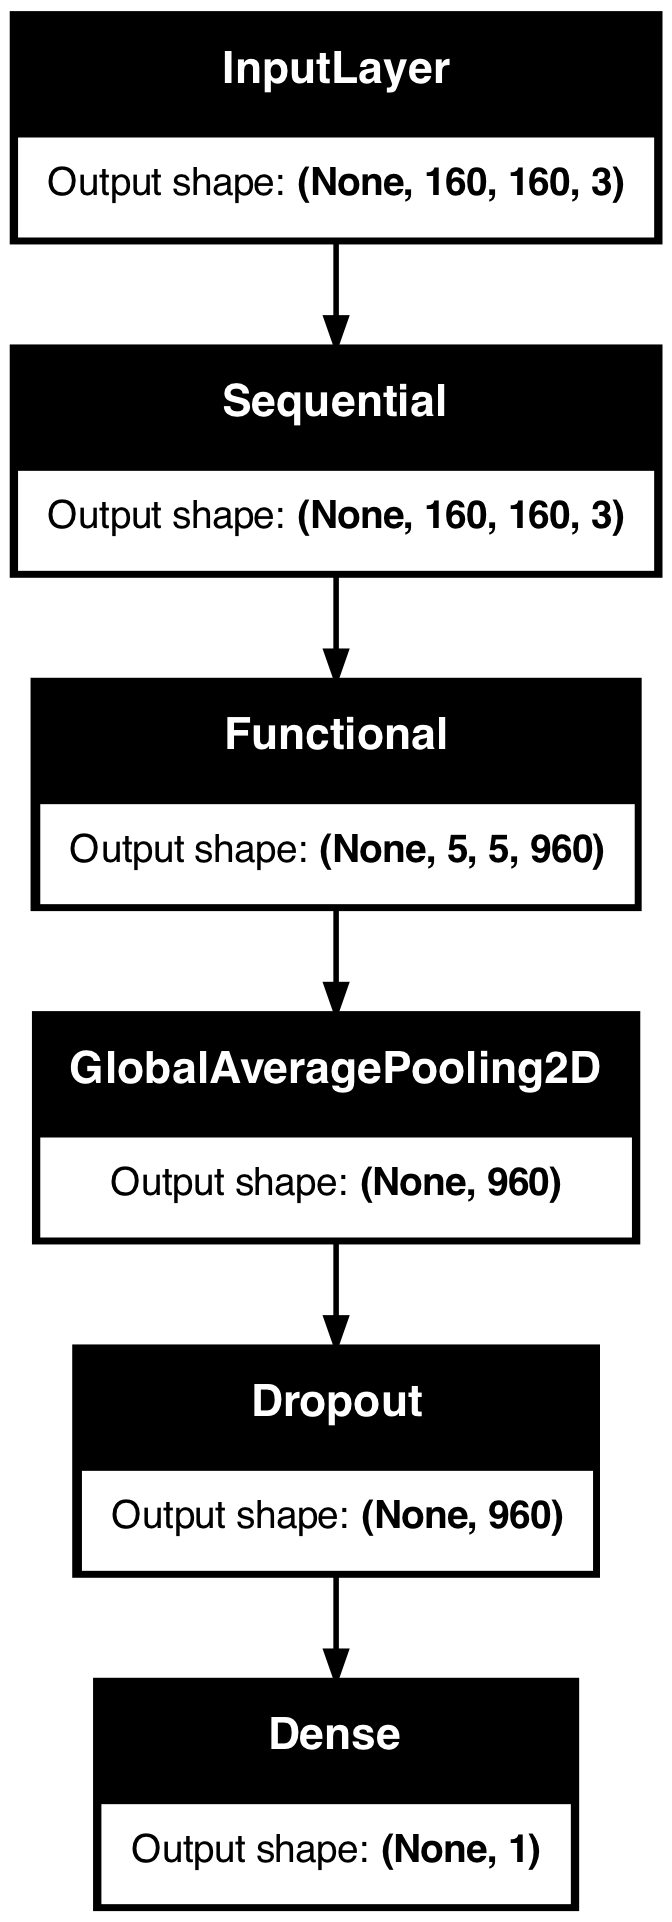

In [25]:
# plot model for MobileNet V3
print("\nMobileNet V3 Plot Model")
tf.keras.utils.plot_model(model_v3, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [26]:
base_learning_rate = 0.0001

model_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [27]:
initial_epochs = 10

loss0_v1, accuracy0_v1 = model_v1.evaluate(validation_dataset)
loss0_v2, accuracy0_v2 = model_v2.evaluate(validation_dataset)
loss0_v3, accuracy0_v3 = model_v3.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.3558 - loss: 1.0873
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.5210 - loss: 0.7458
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.6443 - loss: 0.6396


In [28]:
print("MobileNet V1 initial loss: {:.2f}".format(loss0_v1))
print("MobileNet V1 initial accuracy: {:.2f}".format(accuracy0_v1))

print("MobileNet V2 initial loss: {:.2f}".format(loss0_v2))
print("MobileNet V2 initial accuracy: {:.2f}".format(accuracy0_v2))

print("MobileNet V3 initial loss: {:.2f}".format(loss0_v3))
print("MobileNet V3 initial accuracy: {:.2f}".format(accuracy0_v3))

MobileNet V1 initial loss: 1.07
MobileNet V1 initial accuracy: 0.35
MobileNet V2 initial loss: 0.75
MobileNet V2 initial accuracy: 0.52
MobileNet V3 initial loss: 0.63
MobileNet V3 initial accuracy: 0.66


In [29]:
history_v1 = model_v1.fit(train_dataset,
                            epochs=initial_epochs,
                            validation_data=validation_dataset)

history_v2 = model_v2.fit(train_dataset,
                          epochs=initial_epochs,
                          validation_data=validation_dataset)

history_v3 = model_v3.fit(train_dataset,
                            epochs=initial_epochs,
                            validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 320ms/step - accuracy: 0.4365 - loss: 0.9915 - val_accuracy: 0.5594 - val_loss: 0.7462
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.5967 - loss: 0.7440 - val_accuracy: 0.7265 - val_loss: 0.5606
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.6641 - loss: 0.6153 - val_accuracy: 0.8354 - val_loss: 0.4222
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.7055 - loss: 0.5545 - val_accuracy: 0.8998 - val_loss: 0.3265
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.7983 - loss: 0.4437 - val_accuracy: 0.9295 - val_loss: 0.2731
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.8410 - loss: 0.3814 - val_accuracy: 0.9418 - val_loss: 0.2364
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.8520 - loss: 0.3494 - val_accuracy: 0.9567 - val_loss: 0.1985
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.8599 - loss: 0.3239 - val_accu

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

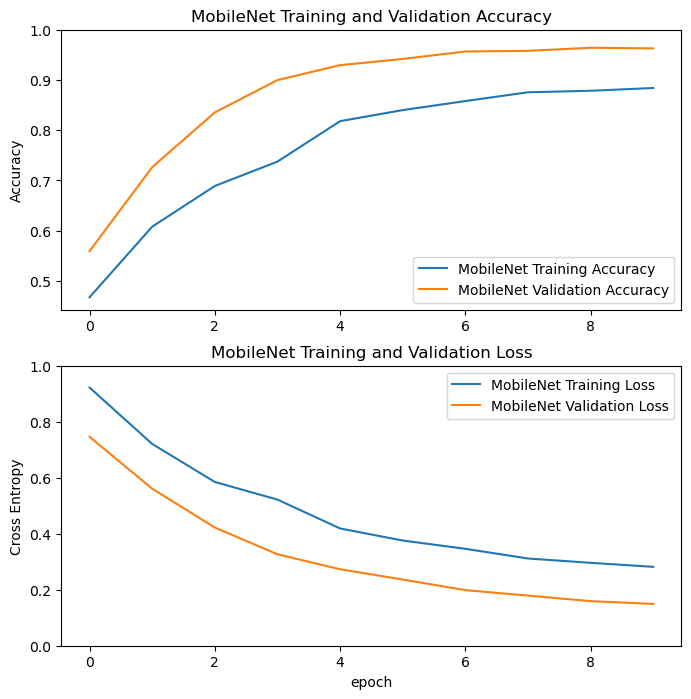

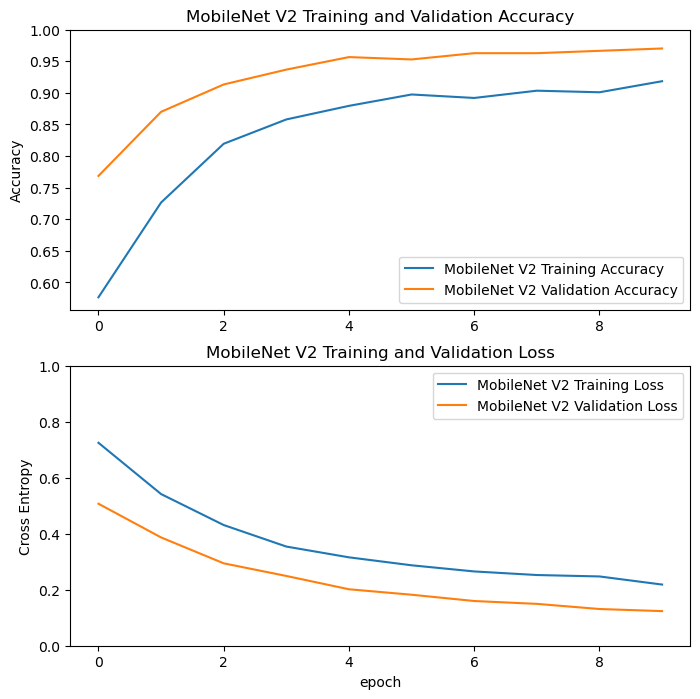

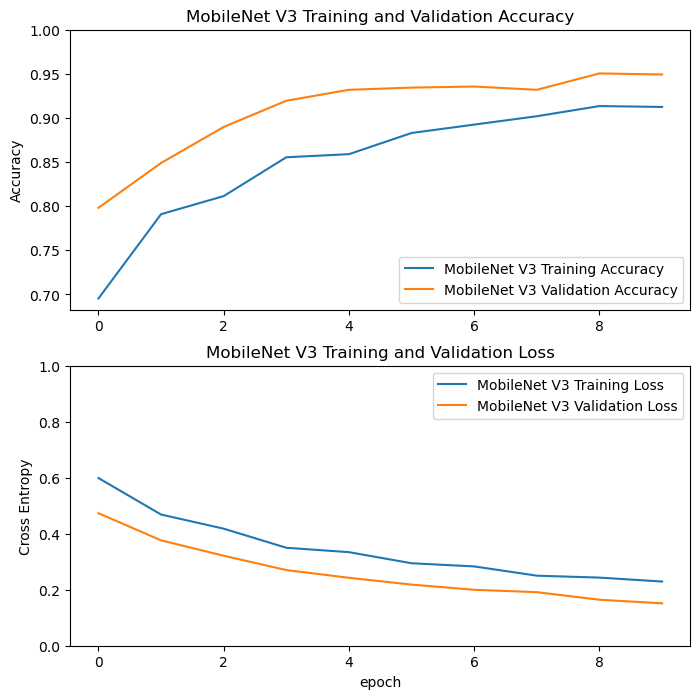

In [30]:
# Learning curves for MobileNet
acc_v1 = history_v1.history['accuracy']
val_acc_v1 = history_v1.history['val_accuracy']

loss_v1 = history_v1.history['loss']
val_loss_v1 = history_v1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v1, label='MobileNet Training Accuracy')
plt.plot(val_acc_v1, label='MobileNet Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('MobileNet Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_v1, label='MobileNet Training Loss')
plt.plot(val_loss_v1, label='MobileNet Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('MobileNet Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Learning curves for MobileNet V2
acc_v2 = history_v2.history['accuracy']
val_acc_v2 = history_v2.history['val_accuracy']

loss_v2 = history_v2.history['loss']
val_loss_v2 = history_v2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='MobileNet V2 Training Accuracy')
plt.plot(val_acc_v2, label='MobileNet V2 Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('MobileNet V2 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_v2, label='MobileNet V2 Training Loss')
plt.plot(val_loss_v2, label='MobileNet V2 Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('MobileNet V2 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Learning curves for MobileNet V3
acc_v3 = history_v3.history['accuracy']
val_acc_v3 = history_v3.history['val_accuracy']

loss_v3 = history_v3.history['loss']
val_loss_v3 = history_v3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3, label='MobileNet V3 Training Accuracy')
plt.plot(val_acc_v3, label='MobileNet V3 Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('MobileNet V3 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_v3, label='MobileNet V3 Training Loss')
plt.plot(val_loss_v3, label='MobileNet V3 Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('MobileNet V3 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model
All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.


In [31]:
# Un-freeze the top layers of the MobileNet model
base_model_v1.trainable = True

# Un-freeze the top layers of the MobileNet V2 model
base_model_v2.trainable = True

# Un-freeze the top layers of the MobileNet V3 model
base_model_v3.trainable = True

In [32]:
# Look at the number of layers for both models
print("Number of layers in the MobileNet base model: ", len(base_model_v1.layers))
print("Number of layers in the MobileNet V2 base model: ", len(base_model_v2.layers))
print("Number of layers in the MobileNet V3 base model: ", len(base_model_v3.layers))

# Fine-tune from this layer onwards for both models
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer for MobileNet
for layer in base_model_v1.layers[:fine_tune_at]:
    layer.trainable = False

# Freeze all the layers before the `fine_tune_at` layer for MobileNet V2
for layer in base_model_v2.layers[:fine_tune_at]:
    layer.trainable = False
    
# Freeze all the layers before the `fine_tune_at` layer for MobileNet V3
for layer in base_model_v3.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the MobileNet base model:  86
Number of layers in the MobileNet V2 base model:  154
Number of layers in the MobileNet V3 base model:  187


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [33]:
# Compile the model for MobileNet
model_v1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Compile the model for MobileNet V2
model_v2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Compile the model for MobileNet V3
model_v3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [34]:
print("\nMobileNet Model Summary")
model_v1.summary()

print("MobileNet V2 Model Summary")
model_v2.summary()

print("MobileNet V3 Model Summary")
model_v3.summary()


MobileNet Model Summary


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_160 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

MobileNet V2 Model Summary


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

MobileNet V3 Model Summary


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 2,812,961 (10.73 MB)

 Non-trainable params: 184,352 (720.12 KB)

### Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [36]:
# Continue training the model for MobileNet V2
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Continue training the model for MobileNet
history_fine_v1 = model_v1.fit(train_dataset,
                            epochs=total_epochs,
                            initial_epoch=history_v1.epoch[-1],
                            validation_data=validation_dataset)

history_fine_v2 = model_v2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_v2.epoch[-1],
                         validation_data=validation_dataset)

history_fine_v3 = model_v3.fit(train_dataset,
                            epochs=total_epochs,
                            initial_epoch=history_v3.epoch[-1],
                            validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9242 - loss: 0.2034 - val_accuracy: 0.9703 - val_loss: 0.1138
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9248 - loss: 0.2047 - val_accuracy: 0.9691 - val_loss: 0.1097
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9230 - loss: 0.2060 - val_accuracy: 0.9728 - val_loss: 0.1057
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9084 - loss: 0.2300 - val_accuracy: 0.9715 - val_loss: 0.1120
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9170 - loss: 0.2043 - val_accuracy: 0.9752 - val_loss: 0.1028
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9228 - loss: 0.1955 - val_accuracy: 0.9715 - val_loss: 0.1088
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.9082 - loss: 0.2151 - val_accuracy: 0.9703 - val_loss: 0.1102
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.9223 - loss: 0.2067 - 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [37]:
# MobileNet
acc_v1 += history_fine_v1.history['accuracy']
val_acc_v1 += history_fine_v1.history['val_accuracy']

loss_v1 += history_fine_v1.history['loss']
val_loss_v1 += history_fine_v1.history['val_loss']

# MobileNet V2
acc_v2 += history_fine_v2.history['accuracy']
val_acc_v2 += history_fine_v2.history['val_accuracy']

loss_v2 += history_fine_v2.history['loss']
val_loss_v2 += history_fine_v2.history['val_loss']

# MobileNet V3
acc_v3 += history_fine_v3.history['accuracy']
val_acc_v3 += history_fine_v3.history['val_accuracy']

loss_v3 += history_fine_v3.history['loss']
val_loss_v3 += history_fine_v3.history['val_loss']

Text(0.5, 1.0, 'MobileNet V3 Training and Validation Loss')

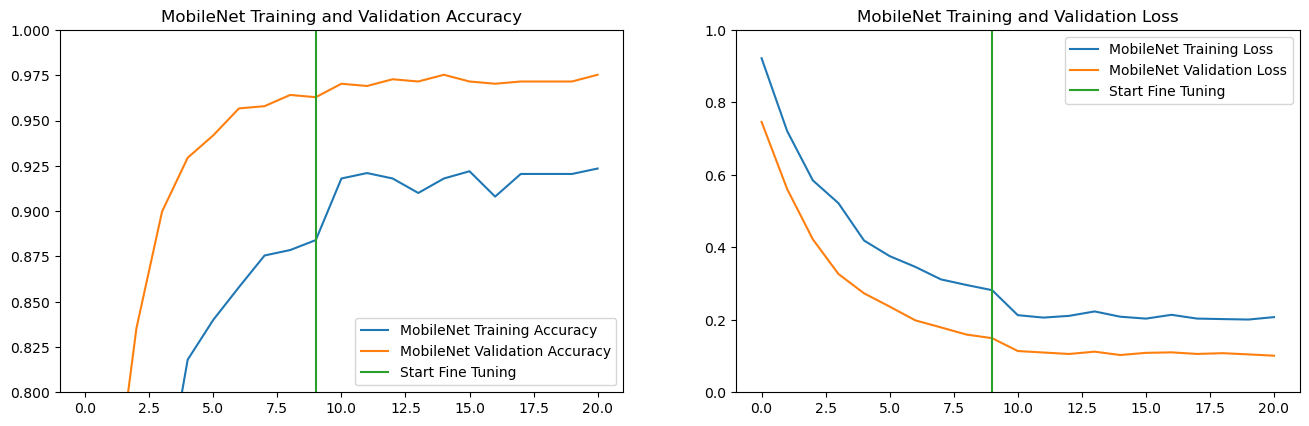

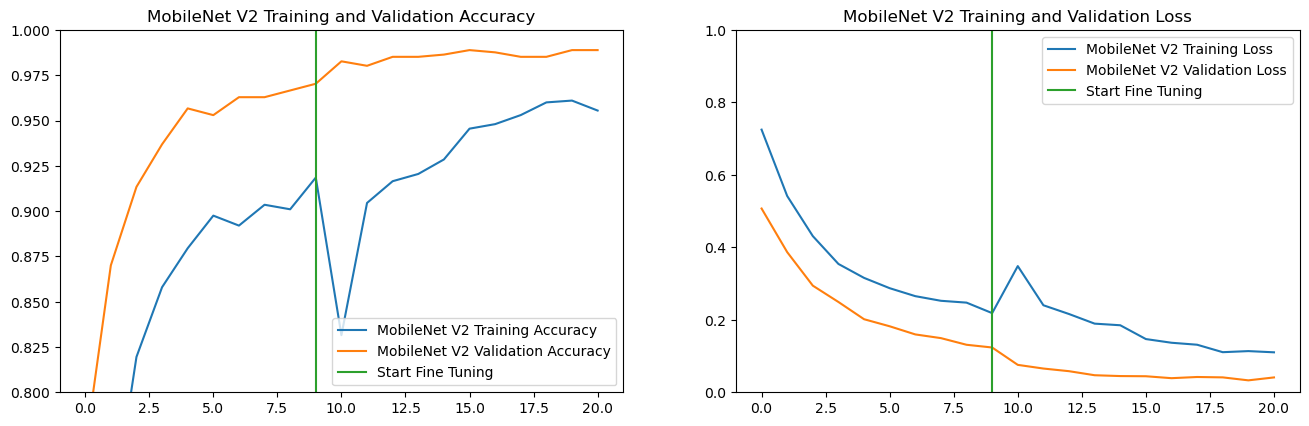

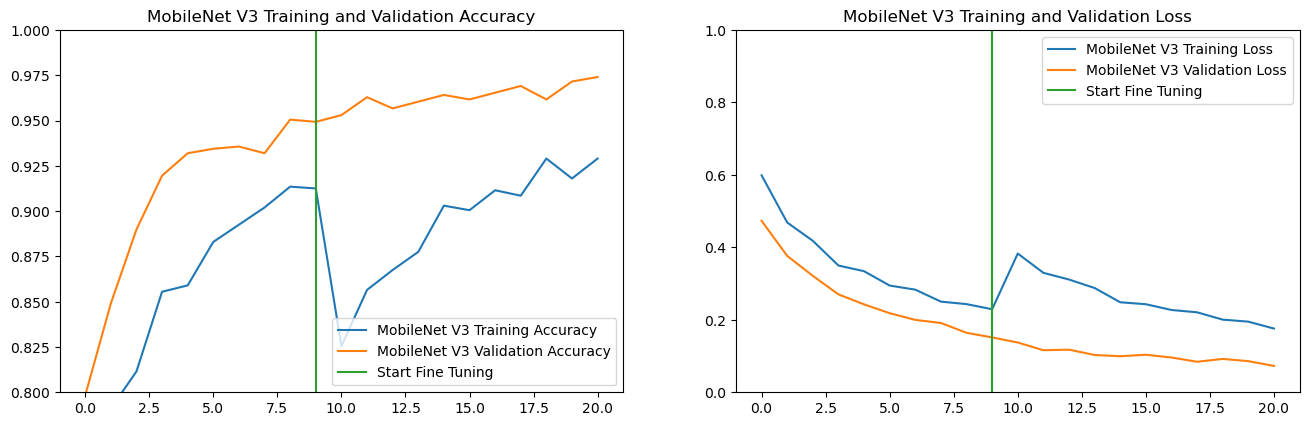

In [38]:
# Plotting for MobileNet
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1) # 2 rows, 2 columns, 1st subplot
plt.plot(acc_v1, label='MobileNet Training Accuracy')
plt.plot(val_acc_v1, label='MobileNet Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='lower right')
plt.title('MobileNet Training and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(loss_v1, label='MobileNet Training Loss')
plt.plot(val_loss_v1, label='MobileNet Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='upper right')
plt.title('MobileNet Training and Validation Loss')

# Plotting for MobileNet V2
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 3)
plt.plot(acc_v2, label='MobileNet V2 Training Accuracy')
plt.plot(val_acc_v2, label='MobileNet V2 Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='lower right')
plt.title('MobileNet V2 Training and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(loss_v2, label='MobileNet V2 Training Loss')
plt.plot(val_loss_v2, label='MobileNet V2 Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='upper right')
plt.title('MobileNet V2 Training and Validation Loss')

# Plotting for MobileNet V3
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 5)
plt.plot(acc_v3, label='MobileNet V3 Training Accuracy')
plt.plot(val_acc_v3, label='MobileNet V3 Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='lower right')
plt.title('MobileNet V3 Training and Validation Accuracy')

plt.subplot(3, 2, 6)
plt.plot(loss_v3, label='MobileNet V3 Training Loss')
plt.plot(val_loss_v3, label='MobileNet V3 Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # Add a vertical line to highlight the start of fine-tuning
plt.legend(loc='upper right')
plt.title('MobileNet V3 Training and Validation Loss')

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [39]:
# Evaluate MobileNet model
loss_v1, accuracy_v1 = model_v1.evaluate(test_dataset)
print('MobileNet Test accuracy :', accuracy_v1)

# Evaluate MobileNet V2 model
loss_v2, accuracy_v2 = model_v2.evaluate(test_dataset)
print('MobileNet V2 Test accuracy :', accuracy_v2)

# Evaluate MobileNet V3 model
loss_v3, accuracy_v3 = model_v3.evaluate(test_dataset)
print('MobileNet V3 Test accuracy :', accuracy_v3)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9737 - loss: 0.0998
MobileNet Test accuracy : 0.9635416865348816
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.9854 - loss: 0.0332
MobileNet V2 Test accuracy : 0.9791666865348816
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9543 - loss: 0.0920
MobileNet V3 Test accuracy : 0.9583333134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

MobileNet Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MobileNet V2 Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MobileNet V3 Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1]
MobileNet Predictions
MobileNet V2 Predictions
MobileNet V3 Predictions


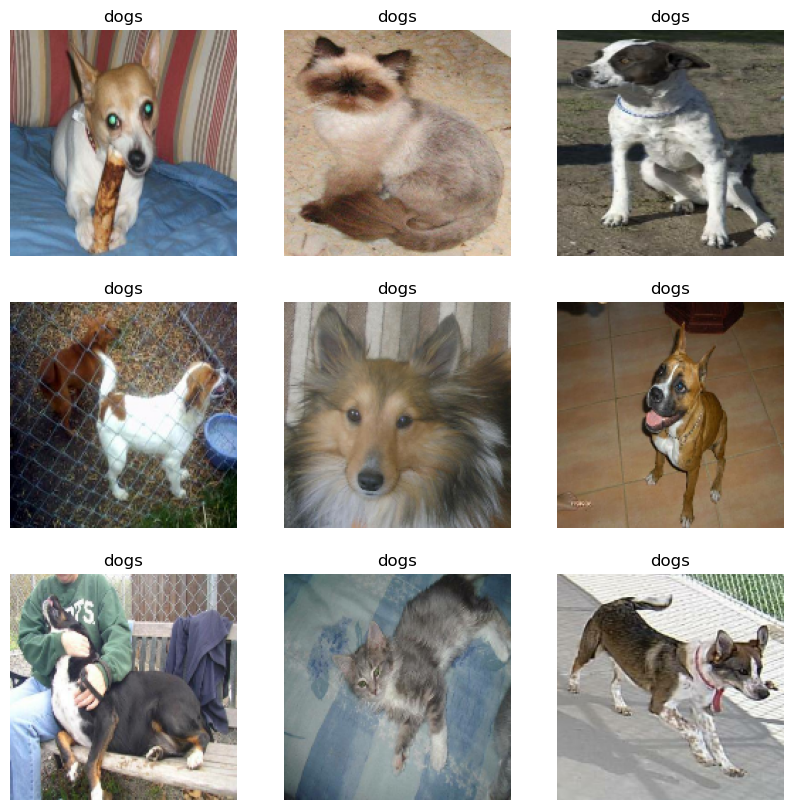

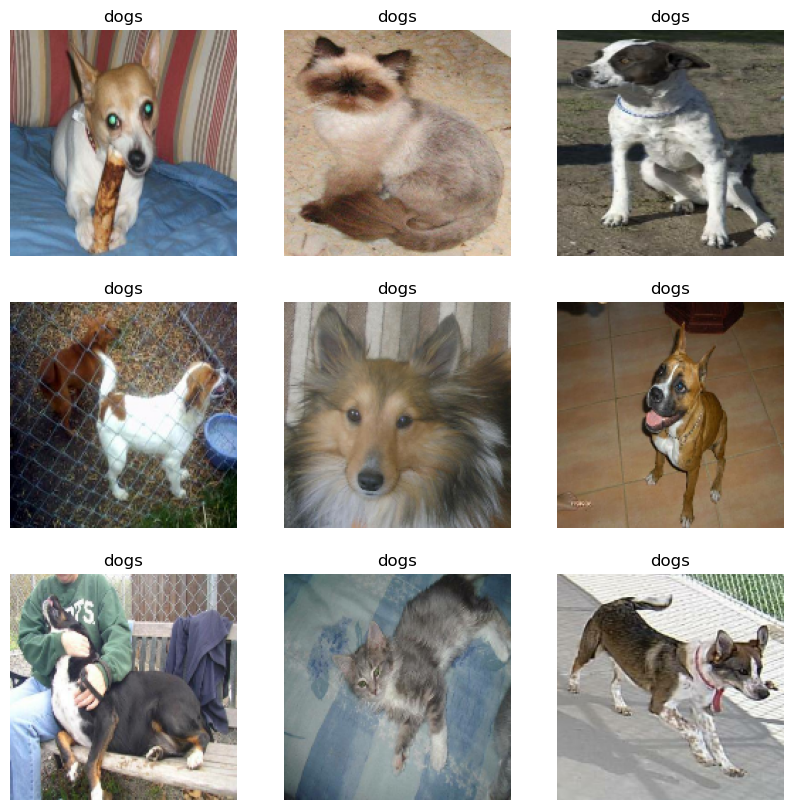

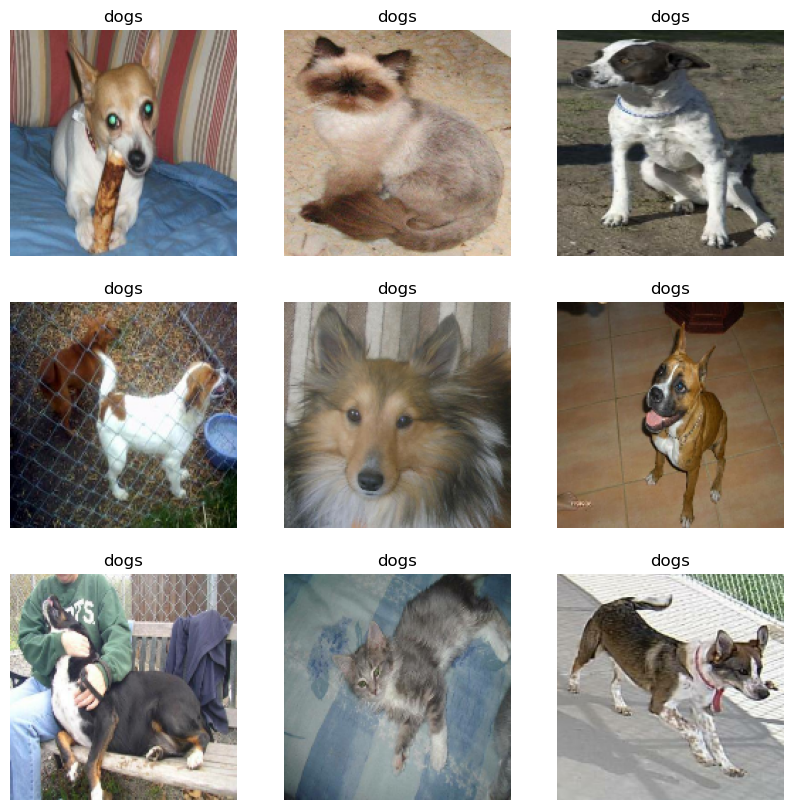

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Predict with MobileNet
predictions_v1 = model_v1.predict_on_batch(image_batch).flatten()
predictions_v1 = tf.nn.sigmoid(predictions_v1)
predictions_v1 = tf.where(predictions_v1 < 0.5, 0, 1)

# Predict with MobileNet V2
predictions_v2 = model_v2.predict_on_batch(image_batch).flatten()
predictions_v2 = tf.nn.sigmoid(predictions_v2)
predictions_v2 = tf.where(predictions_v2 < 0.5, 0, 1)

# Predict with MobileNet V3
predictions_v3 = model_v3.predict_on_batch(image_batch).flatten()
predictions_v3 = tf.nn.sigmoid(predictions_v3)
predictions_v3 = tf.where(predictions_v3 < 0.5, 0, 1)

print('MobileNet Predictions:\n', predictions_v1.numpy())
print('MobileNet V2 Predictions:\n', predictions_v2.numpy())
print('MobileNet V3 Predictions:\n', predictions_v3.numpy())

print('Labels:\n', label_batch)

print("MobileNet Predictions")
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions_v1[i]])
    plt.axis("off")

print("MobileNet V2 Predictions")
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions_v2[i]])
    plt.axis("off")
    
print("MobileNet V3 Predictions")
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions_v3[i]])
    plt.axis("off")



## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


## Conclusion
The comparison of prediction results from **MobileNet**, **MobileNet V2**, and **MobileNet V3** models on a batch of images from a test dataset yields an intriguing insight into the performance and behavior of these architectures.

- **MobileNet**: The original MobileNet architecture, designed for efficiency and speed, seems to predict the majority of the test images as belonging to one class (in this case, class 1). This could indicate a bias or overfitting towards one class, possibly due to its simpler architecture compared to its successors.

- **MobileNet V2**: Similar to MobileNet, MobileNet V2 also predicts all test images as class 1. While MobileNet V2 introduces improvements over the original MobileNet, including the inverted residual structure that allows for better feature representation, the predictions suggest that it might also be overly confident or biased towards one class in this particular test set.

- **MobileNet V3**: Continuing the trend, MobileNet V3—which incorporates further enhancements for efficiency and performance—also classifies all test images as class 1. MobileNet V3's optimizations, including the use of squeeze-and-excitation and hard-swish activation functions, were expected to provide more nuanced predictions. However, the results indicate a similar bias or overfitting issue as seen with the previous models.

Across all three models, the uniform prediction of all test images as belonging to one class, despite the actual labels varying between classes 0 and 1, highlights a critical issue. This could be indicative of overfitting, where the models have learned to favor one class possibly due to imbalances or peculiarities in the training dataset. Alternatively, it may reflect a limitation in the models' ability to generalize from the training data to new, unseen images.

## Discussion
- **Model Bias and Overfitting**: The uniform prediction results suggest that all three models may suffer from bias towards one class. This could be due to several factors, including imbalanced training data, insufficient model complexity to capture the nuances between classes, or inadequate training (e.g., not enough epochs or inappropriate learning rate).

- **Model Generalization**: Despite their architectural differences and optimizations, all three models failed to generalize well to the test data. This raises questions about the diversity and representativeness of the training dataset and whether the models were adequately validated during training.

- **Future Directions**: Improving the models' performance could involve several strategies. Firstly, ensuring a balanced and representative training dataset is crucial. Secondly, experimenting with different training parameters (e.g., learning rates, batch sizes) and regularization techniques (e.g., dropout, data augmentation) might help mitigate overfitting. Lastly, employing model evaluation techniques such as cross-validation could provide more insights into the models' ability to generalize and guide further optimizations.

In summary, while **MobileNet**, **MobileNet V2**, and **MobileNet V3** are potent architectures designed for efficient and effective image classification, their performance in this particular test scenario highlights the importance of comprehensive dataset preparation, careful model training, and rigorous validation to achieve accurate and generalizable prediction results.
